In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
from matplotlib.ticker import NullFormatter
import pandas as pd
import os
import torch
%matplotlib inline
import time

from matplotlib import rc
matplotlib.rcParams.update({'font.size': 15})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True) #can't plot some basic text like _?

# Vanilla Training

In [14]:
class VanillaExperimentParser(object):
    def __init__(self, exp_folder):
        self.exp_folder = exp_folder
        self.parse_logs()
    
    def parse_logs(self, max_n_runs=1000, drop_last=True):       
        csv_path = os.path.join(self.exp_folder, 'log.csv')
        self.df = pd.read_csv(csv_path)
        
def plot_variability(experiment_path, x_range=None, y_range=None, title=None):
    exp = VanillaExperimentParser(experiment_path)

    plt.scatter(exp.df['TRAIN/grads_mean_abs'], exp.df['TRAIN/current_train_loss_drop'], c=range(len(exp.df['TRAIN/grads_mean_abs'])), cmap='rainbow')
    #plt.scatter(exp.df['TRAIN/grads_mean_abs'], exp.df['TRAIN/next_train_loss_drop'], c=range(len(exp.df['TRAIN/grads_mean_abs'])), cmap='rainbow')
    
    plt.xlabel('grad mean abs')
    plt.ylabel('train loss change'); #-ve means loss decreased
    cbar = plt.colorbar()
    cbar.set_label('batch idx')
    if x_range is not None: plt.xlim(*x_range)
    if y_range is not None: plt.ylim(*y_range)
    if title is not None: plt.title(title)

In [85]:
master_folder_vanilla = '/home/paul/LOCAL_logs/GreedyGrad/grad_loss_correlation_baselines'

### Cosine BN

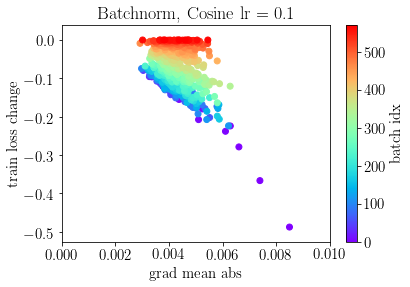

In [84]:
experiment_folder = master_folder_vanilla + '/RBASELINE_FashionMNIST_LeNetBN_ReLUcosine_nb573_ilr0.1_tbs128_mom0.0_wd0.0'
plot_variability(experiment_folder, x_range=(0,0.01), title='Batchnorm, Cosine lr = 0.1')
#Train Acc: 88.49% -- Test Acc: 86.83%

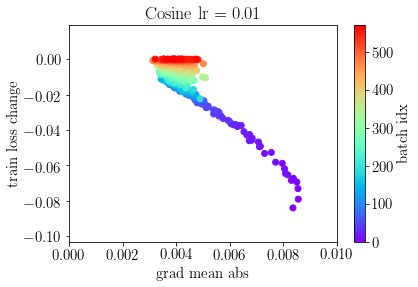

In [86]:
experiment_folder = master_folder_vanilla + '/RBASELINE_FashionMNIST_LeNetBN_ReLUcosine_nb573_ilr0.01_tbs128_mom0.0_wd0.0'
plot_variability(experiment_folder, x_range=(0,0.01), title='Cosine lr = 0.01')
#Train Acc: 77.59% -- Test Acc: 77.20%

### Cosine NoBN

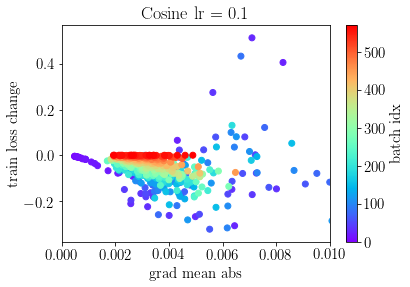

In [71]:
experiment_folder = master_folder_vanilla + '/RBASELINE_FashionMNIST_LeNetNone_ReLUcosine_nb573_ilr0.1_tbs128_mom0.0_wd0.0'
plot_variability(experiment_folder, x_range=(0,0.01), title='Cosine lr = 0.1')
#Train Acc: 79.74% -- Test Acc: 79.09%

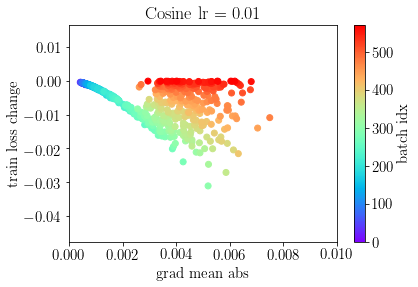

In [72]:
experiment_folder = master_folder_vanilla + '/RBASELINE_FashionMNIST_LeNetNone_ReLUcosine_nb573_ilr0.01_tbs128_mom0.0_wd0.0'
plot_variability(experiment_folder, x_range=(0,0.01), title='Cosine lr = 0.01')
#Train Acc: 59.67% -- Test Acc: 59.38%

### Fixed lr BN

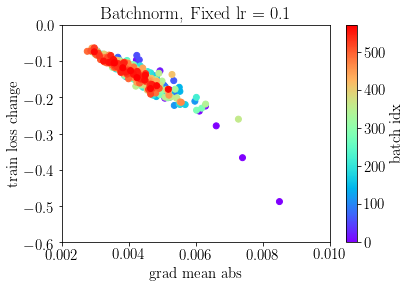

In [82]:
experiment_folder = master_folder_vanilla + '/RBASELINE_FashionMNIST_LeNetBN_ReLUfixed_nb573_ilr0.1_tbs128_mom0.0_wd0.0'
plot_variability(experiment_folder, y_range=(-0.6, 0.0), x_range=(0.002, 0.010), title='Batchnorm, Fixed lr = 0.1')

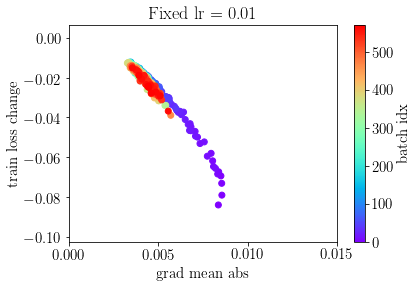

In [68]:
experiment_folder = '/home/paul/git/GreedyGrad/logs/grad_loss_correlation/RBASELINE_FashionMNIST_LeNetBN_ReLUfixed_nb573_ilr0.01_tbs128_mom0.0_wd0.0'
plot_variability(experiment_folder, x_range=(0,0.015), title='Fixed lr = 0.01')

### Fixed lr noBN

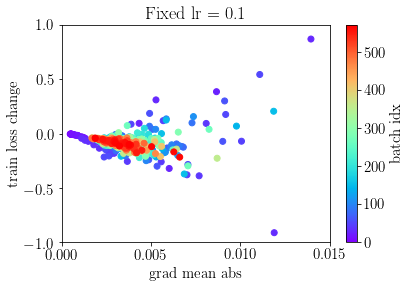

In [76]:
experiment_folder = master_folder_vanilla + '/RBASELINE_FashionMNIST_LeNetNone_ReLUfixed_nb573_ilr0.1_tbs128_mom0.0_wd0.0'
plot_variability(experiment_folder, y_range=(-1, 1), x_range=(0,0.015), title='Fixed lr = 0.1')

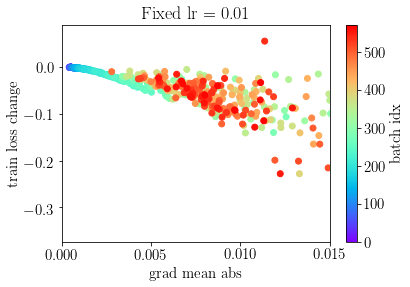

In [70]:
experiment_folder = master_folder_vanilla + '/RBASELINE_FashionMNIST_LeNetNone_ReLUfixed_nb573_ilr0.01_tbs128_mom0.0_wd0.0'
plot_variability(experiment_folder, x_range=(0,0.015), title='Fixed lr = 0.01')
# Final: Train Acc: 66.91% -- Test Acc: 66.24%

# Meta training

In [153]:
class MetaExperimentParser(object):

    def __init__(self, experiment_path):
        self.experiment_path = experiment_path
        self.logs_meta_path = os.path.join(experiment_path, 'logs_meta.pth.tar')
        self.parse_args()
        self.parse_logs()

    def parse_args(self):
        args_path = os.path.join(self.experiment_path, 'args.txt')
        df = pd.read_csv(args_path, sep='\t', header=None, usecols=[0,1], names=['keys', 'values'])
        self.args = {k.strip():v.strip() for k,v in zip(df['keys'], df['values'])}


    def parse_logs(self):
        logs_meta = torch.load(self.logs_meta_path, map_location=torch.device('cpu'))
        self.val_losses_delta = logs_meta['val_losses_delta'].numpy()
        self.lr_schedule = logs_meta['lr_schedule'].numpy()
        self.mom_schedule = logs_meta['mom_schedule'].numpy()
        self.wd_schedule = logs_meta['wd_schedule'].numpy()
        self.lr_raw_grads = logs_meta['lr_raw_grads'].numpy()
        self.lr_raw_smooth = logs_meta['lr_raw_smooth'].numpy()
        self.mom_raw_grads = logs_meta['mom_raw_grads'].numpy()
        self.mom_raw_smooth = logs_meta['mom_raw_smooth'].numpy()
        self.wd_raw_grads = logs_meta['wd_raw_grads'].numpy()
        self.wd_raw_smooth = logs_meta['wd_raw_smooth'].numpy()
        self.chunk_idx = logs_meta['chunk_idx'] 
        self.outer_step_idx = logs_meta['outer_step_idx'] 
        
        self.n_outer_steps = self.val_losses_delta.shape[0]
        self.n_chunks = self.val_losses_delta.shape[1]
        self.n_batches = self.lr_schedule.shape[1]
        self.n_chunks_centers = np.linspace(self.n_batches/(2*self.n_chunks), self.n_batches, self.n_chunks)
    
    
def plot_variability(experiment_path, to_plot, x_range=None, y_range=None, title=None):
    assert to_plot in ['lr', 'mom', 'wd']
    exp = MetaExperimentParser(experiment_path)
    print(f'# of chunks: {exp.chunk_idx+1}/{exp.n_chunks}')
    print(f'# of outer_steps on last chunk: {exp.outer_step_idx+1}/{exp.n_outer_steps}')

    if to_plot=='lr': raw_grads_abs_mean = np.mean(np.abs(exp.lr_raw_grads), axis=-1)
    if to_plot=='mom': raw_grads_abs_mean = np.mean(np.abs(exp.mom_raw_grads), axis=-1)
    if to_plot=='wd': raw_grads_abs_mean = np.mean(np.abs(exp.wd_raw_grads), axis=-1)

    val_deltas, hypergrads = [], []

    for chunk_idx in range(exp.chunk_idx+1):
        last_chunk = chunk_idx==exp.chunk_idx
        for outer_step_idx in range(exp.n_outer_steps): #don't compute val loss for last hyper step, but do get grads which are ignored
            if last_chunk and outer_step_idx == exp.outer_step_idx: break
            val_deltas.append(exp.val_losses_delta[outer_step_idx, chunk_idx])
            hypergrads.append(raw_grads_abs_mean[outer_step_idx, chunk_idx])

        if last_chunk: break

    plt.scatter(hypergrads, val_deltas, c=range(len(val_deltas)), cmap='rainbow')
    plt.xlabel('Hypergrad mean abs')
    plt.ylabel('Validation change'); #-ve means loss decreased
    cbar = plt.colorbar()
    cbar.set_label('batch idx')
    if x_range is not None: plt.xlim(*x_range)
    if y_range is not None: plt.ylim(*y_range)
    if title is not None: plt.title(title)


In [91]:
master_folder_meta = '/home/paul/git/GreedyGrad/logs'

# of chunks: 2/23
# of outer_steps on last chunk: 32/100


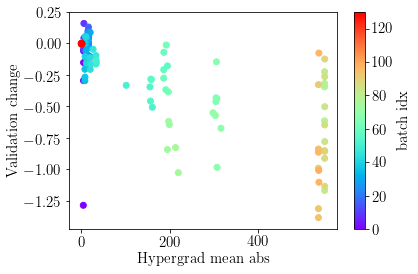

In [99]:
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb460_nc23_nos100_tbs256_iSGD_lr0.0_mom0.0_wd0.0_olr0.01_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path)

# of chunks: 1/1
# of outer_steps on last chunk: 36/100


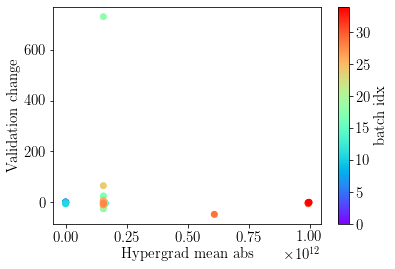

In [101]:
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb50_nc1_nos100_tbs256_iSGD_lr0.0_mom0.9_wd0.0005_olr0.01_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path)

# of chunks: 1/1
# of outer_steps on last chunk: 15/100


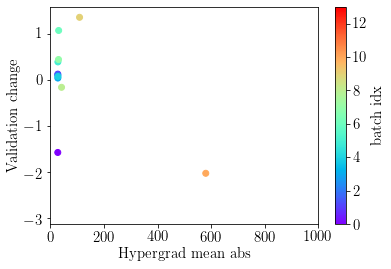

In [106]:
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb20_nc1_nos100_tbs256_iSGD_lr0.0_mom0.9_wd0.0005_olr0.01_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=(0,1000))

# of chunks: 1/1
# of outer_steps on last chunk: 81/100


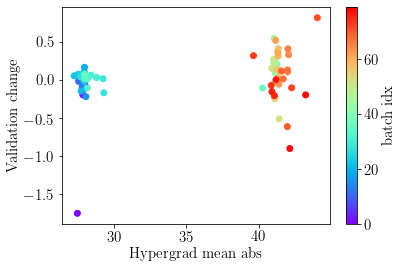

In [109]:
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb20_nc1_nos100_tbs256_iSGD_lr0.0_mom0.9_wd0.0005_olr0.001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

## Val batch size

lr = 0.0001. , n_batches = 20, nc=1. Val size doesn't seem to matter much

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


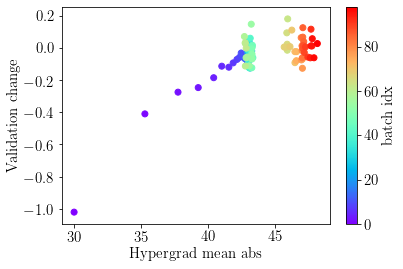

In [118]:
#vbs1000
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb20_nc1_nos100_tbs128_vbs1000_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


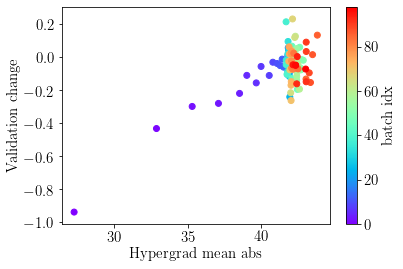

In [119]:
#vbs128
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb20_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

## Learning rate

fixed vbs128, n_batches = 20, nc=1. The smaller the lr the higher the hypergrads are, probably because we get down so local minima that have higher curvature. Overall if we take the most sensible choice of lr though (biggest that doesn't break) we get a reverse trend from vanilla training: high hypergrads reduce the hyperloss less. 

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


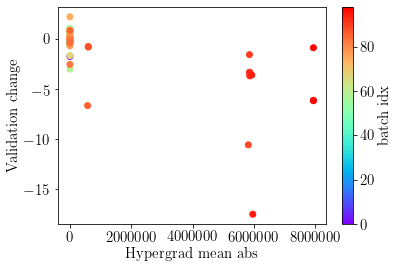

In [123]:
# olr0.001, val accuracy is bad, probably overfits to each val batch sequentially since val change is quite good
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb20_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


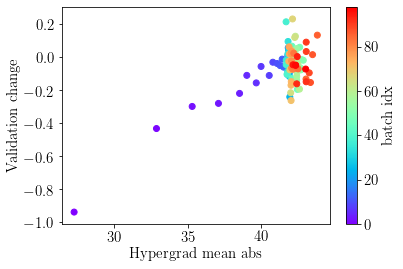

In [120]:
# olr0.0001
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb20_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


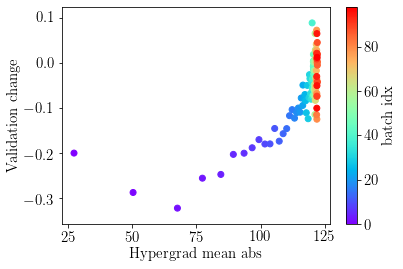

In [122]:
# olr0.00001
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb20_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr1e-05_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


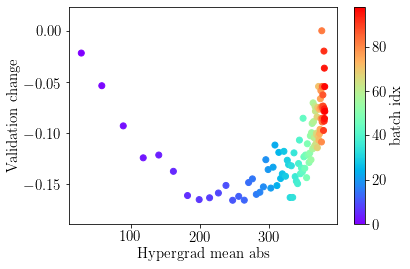

In [124]:
# olr0.000001
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb20_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr1e-06_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

# n_batches

fixed vbs128, olr0.0001

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


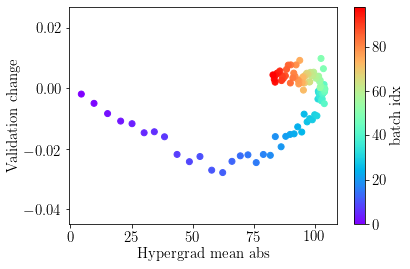

In [125]:
# nb1
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb1_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


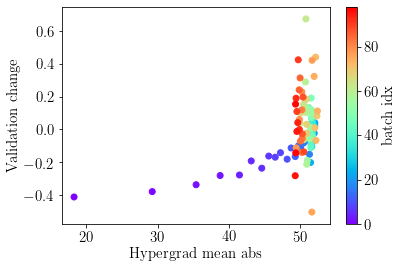

In [126]:
# nb10
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb10_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


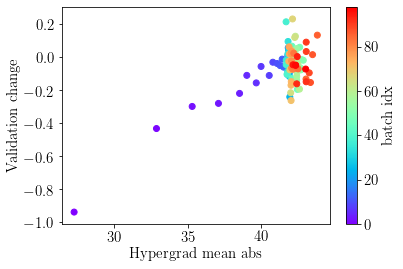

In [120]:
# nb20
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb20_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


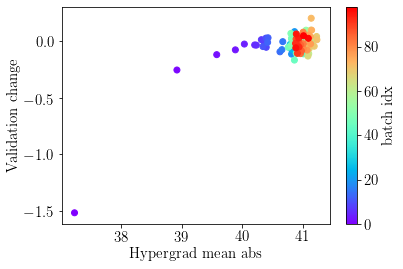

In [127]:
# nb50
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb50_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, x_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


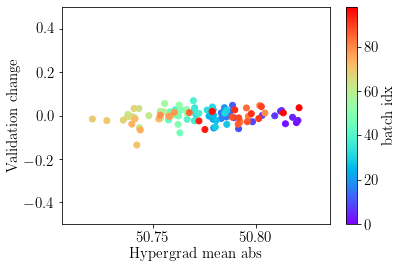

In [130]:
# nb500
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb500_nc1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, y_range=(-0.5, 0.5))

# Disentangled vs entangled

In [91]:
master_folder_meta = '/home/paul/git/GreedyGrad/logs'

## lr

#### mom=0.9, wd=5e-4

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


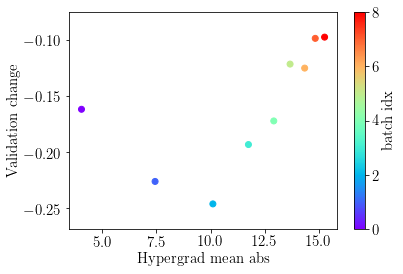

In [139]:
#DISENTANGLED
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_DISENTANGLED_S0'
plot_variability(experiment_path, y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


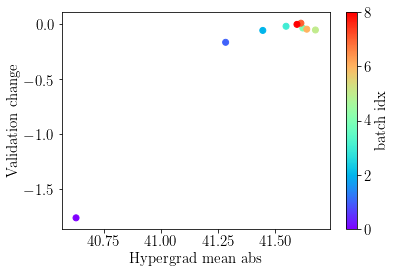

In [143]:
#VANILLA
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.0_mom0.9_wd0.0005_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, y_range=None)

#### mom=0.0, wd=0.0

same, as expected

## mom

### entangled

entangled momentum seems useless if inner learning rate is large enough already

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


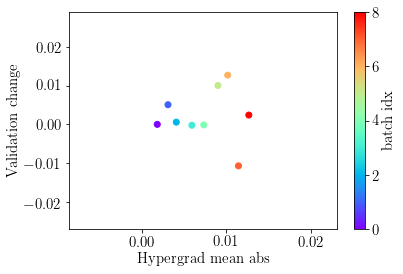

In [154]:
#ilr=0.1, olr=0.0001
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.1_mom0.0_wd0.0_olr0.0001_oSGD_m0.0_learnMOMmpc0.1_S0'
plot_variability(experiment_path, 'mom', y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


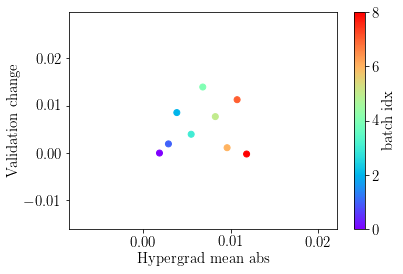

In [163]:
#ilr=0.1, olr=0.01
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.1_mom0.0_wd0.0_olr0.01_oSGD_m0.0_learnMOMmpc0.1_S0'
plot_variability(experiment_path, 'mom', y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


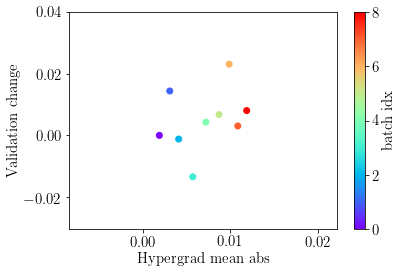

In [157]:
#ilr=0.1, olr=1
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.1_mom0.0_wd0.0_olr1_oSGD_m0.0_learnMOMmpc0.1_S0'
plot_variability(experiment_path,  'mom', y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


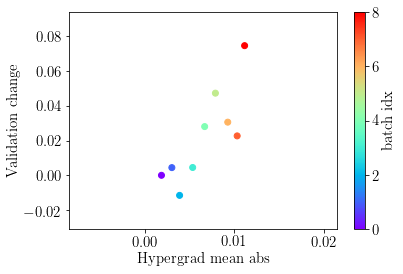

In [158]:
#ilr=0.1, olr=10
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.1_mom0.0_wd0.0_olr10_oSGD_m0.0_learnMOMmpc0.1_S0'
plot_variability(experiment_path,  'mom', y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


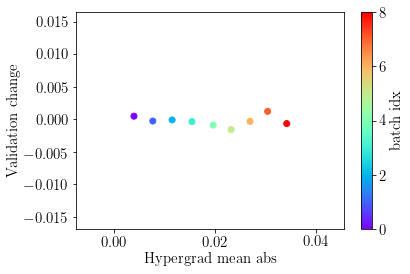

In [161]:
#ilr=0.01, olr=0.1
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.01_mom0.0_wd0.0_olr0.1_oSGD_m0.0_learnMOMmpc0.1_S0'
plot_variability(experiment_path,  'mom', y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


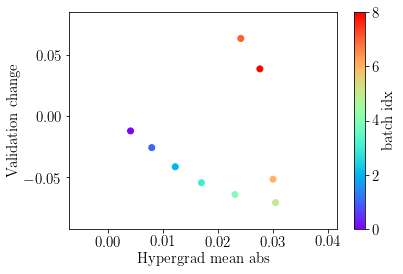

In [159]:
#ilr=0.01, olr=10
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.01_mom0.0_wd0.0_olr10_oSGD_m0.0_learnMOMmpc0.1_S0'
plot_variability(experiment_path,  'mom', y_range=None)

### disentangled

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


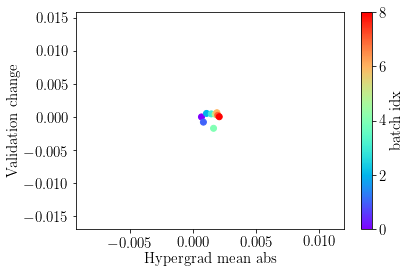

In [169]:
#ilr=0.01, olr=10
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.01_mom0.0_wd0.0_olr10_oSGD_m0.0_learnMOMmpc0.1_DISENTANGLED_S0'
plot_variability(experiment_path,  'mom', y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


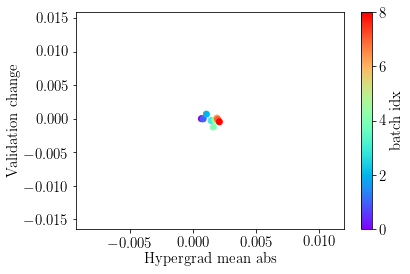

In [166]:
#ilr=0.01, olr=0.1
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.01_mom0.0_wd0.0_olr0.1_oSGD_m0.0_learnMOMmpc0.1_DISENTANGLED_S0'
plot_variability(experiment_path,  'mom', y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


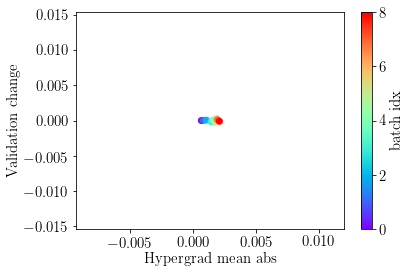

In [171]:
#ilr=0.01, olr=0.001
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.01_mom0.0_wd0.0_olr0.001_oSGD_m0.0_learnMOMmpc0.1_DISENTANGLED_S0'
plot_variability(experiment_path,  'mom', y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 10/10


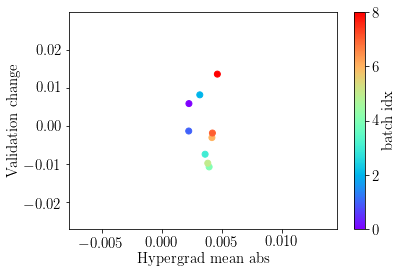

In [168]:
#ilr=0.1, olr=0.1
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nos10_tbs128_vbs128_iSGD_lr0.1_mom0.0_wd0.0_olr0.1_oSGD_m0.0_learnMOMmpc0.1_DISENTANGLED_S0'
plot_variability(experiment_path,  'mom', y_range=None)

## wd

## Share hypers

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


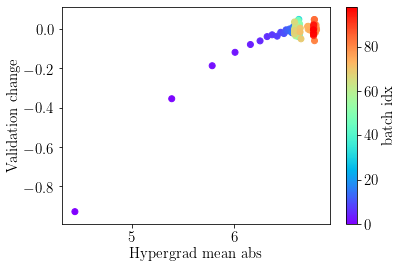

In [173]:
# nhpc=-1, olr=0.001
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nhpc-1_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.0_wd0.0_olr0.001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, 'lr', y_range=None)

# of chunks: 1/1
# of outer_steps on last chunk: 100/100


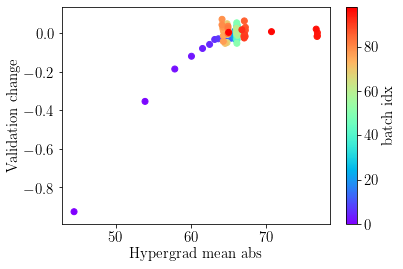

In [174]:
# nhpc=10, olr=0.0001
experiment_path = master_folder_meta + '/RSL_FashionMNIST_LeNet_nBN_ReLU_nb100_nc1_nhpc10_nos100_tbs128_vbs128_iSGD_lr0.0_mom0.0_wd0.0_olr0.0001_oSGD_m0.0_learnLRmpc0.1_S0'
plot_variability(experiment_path, 'lr', y_range=None)